In [1]:
import numpy as np
import dedalus.public as d3

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo

plt.style.use('/mnt/c/Ryan_Data/Python_Tool/ryan_mplstyle.mplstyle')

2023-10-25 09:35:23,437 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.2e+01/s
2023-10-25 09:35:23,988 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2023-10-25 09:35:24,235 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+01/s
2023-10-25 09:35:24,470 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+01/s
2023-10-25 09:35:24,696 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+01/s
2023-10-25 09:35:25,009 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-10-25 09:35:25,285 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-10-25 09:35:25,497 subsystems 0/1 INFO :: Building subproblem matrices 

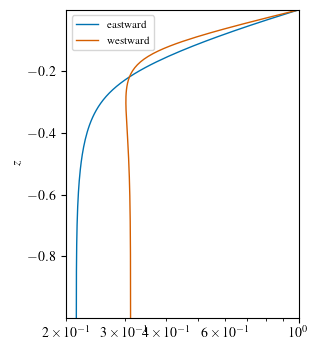

In [5]:
import numpy as np
import dedalus.public as d3

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo

plt.style.use('/mnt/c/Ryan_Data/Python_Tool/ryan_mplstyle.mplstyle')

# Physical Parameters
xin2 = 0.5
Ub = 1
delta = 0.2

# Numerics Parameters
Lz = 1
Nz = 128

dtype = np.complex128

# Bases
Lzt, Lzb = 0, -Lz

coords = d3.CartesianCoordinates('z')
dist = d3.Distributor(coords, dtype=dtype)
zbasis = d3.Chebyshev(coords['z'], size=Nz, bounds=(Lzb, Lzt))


# Mean Fields
N2 = dist.Field(bases=zbasis )
U_M = dist.Field(bases=zbasis )
By_M = dist.Field(bases=zbasis )
Qy_M = dist.Field(bases=zbasis )

# Eigenproblem Fields
omega = dist.Field()

q = dist.Field(name='q', bases=zbasis )
bt = dist.Field(name='bt' )
bb = dist.Field(name='bb' )

P0 = dist.Field(name='P0', bases=zbasis )

tau_P0 = dist.Field()
tau_P0t = dist.Field( )
tau_P0b = dist.Field( )

kx = dist.Field(name='kx')
ky = dist.Field(name='ky')
omega = dist.Field()

# Substitutions
dx = lambda A: 1j*kx*A
dy = lambda A: 1j*ky*A
dz = lambda A: d3.Differentiate(A, coords['z'])
dt = lambda A: -1j*omega*A

z = dist.local_grids(zbasis)[0]

lift_basis = zbasis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)

u = -dy(P0)
v =  dx(P0)

ut = u(z=Lzt); vt = v(z=Lzt); 
ub = u(z=Lzb); vb = v(z=Lzb); 

By_Mt = By_M(z=Lzt); By_Mb = By_M(z=Lzb)
U_Mt = U_M(z=Lzt);   U_Mb = U_M(z=Lzb)

lap = lambda A: dx(dx(A))+dy(dy(A))

# IC
N2['g'] = np.exp(z/delta)


fig=plt.figure(1,figsize=(3, 4))

sign_ary = [1,-1]
text_ary = ["eastward","westward"]

for idx in range(2):
    U_M['g'] = sign_ary[idx]*(1+z-delta)*np.exp(z/delta)/5

    # Problem
    problem_mean = d3.LBVP([By_M, Qy_M], namespace=locals())

    problem_mean.add_equation("By_M = -dz(U_M)")
    problem_mean.add_equation("Qy_M = xin2-Ub*dz(1/N2*dz(U_M))")
    
    # Solver
    solver_mean = problem_mean.build_solver()
    solver_mean.solve()
    Qy_M['g'] = Qy_M['g'][int(Nz/2)] # fix noise in taking derivatives
    
    #####################
    # Problem
    problem = d3.EVP([P0, tau_P0t, tau_P0b, \
                      q, bt\
                      ], eigenvalue=omega, namespace=locals())

    problem.add_equation("lap(P0) + Ub*dz( 1/N2*dz(P0) ) + lift(tau_P0t,-1) + lift(tau_P0b,-2) - q = 0")
    problem.add_equation("dz(P0)(z=Lzt) - bt = 0"); problem.add_equation("dz(P0)(z=Lzb) - 0 = 0")

    problem.add_equation("dt(bt) + U_Mt*dx(bt) + vt*By_Mt = 0")
    # problem.add_equation("dt(bb) + U_Mb*dx(bb) + vb*By_Mb = 0")

    problem.add_equation("dt(q) + U_M*dx(q) + v*Qy_M = 0")
    
    # Solver
    k_ary = np.exp(np.arange(-1.5,4,0.2))
    grow_ary = np.empty([k_ary.size])
    c_ary_1 = np.empty([k_ary.size], dtype=complex)
    c_ary_2 = np.empty([k_ary.size], dtype=complex)

    for ix in range(k_ary.size):
        kx['g'] = k_ary[ix]; ky['g'] = 0

        solver = problem.build_solver()
        solver.solve_dense(solver.subproblems[0], rebuild_matrices=True)
        evals = solver.eigenvalues
        # print(evals.shape)

        e_loc = np.argmax(np.imag(evals))
        grow_ary[ix] = np.imag(evals[e_loc])
            
         
    k_max = k_ary[np.argmax(grow_ary)]
    kx['g'] = k_max; ky['g'] = 0

    solver = problem.build_solver()
    solver.solve_dense(solver.subproblems[0], rebuild_matrices=True)
    evals = solver.eigenvalues
    loc_grow = np.argmax(np.imag(evals))    
    
    solver.set_state(loc_grow,0)
    P0_evec = solver.state[0]['g'] # index 0 because P0 is the first element of the d3.EVP statement
    
    
    # plot
    fig=plt.figure(1)
    plt.semilogx(np.abs(P0_evec)/np.abs(P0_evec[-1]),z,label=text_ary[idx])

fig = plt.figure(1)
plt.legend()
plt.ylabel("$z$")
plt.xlim(0.2,1)

plt.savefig("figs/Charney_evecmag.pdf", bbox_inches='tight')
plt.show()